In [214]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [215]:
#Base cofficients (now: random!)
BASE_WEIGHTS = {
    'age': 0.2,
    'income': 0.15,
    'openness': 0.1,
    'conscientiousness': 0.1,
    'extraversion': 0.1,
    'agreeableness': 0.1,
    'neuroticism': 0.1,
    'depressed_mood': 0.05,
    'anhedonia': 0.05,
    'weight_change': 0.05,
    'sleep_disturbance': 0.05,
    'psychomotor': 0.05,
    'fatigue': 0.05,
    'worthlessness': 0.05,
    'concentration': 0.05,
    'suicidal_ideation': 0.05,
    'total_depressive_symptoms': 0.05,
    'education': 0.1,
    'ethnicity': 0.1,
    'gender': 0.2,
    'religion': 0.1
}

MAX_DISTANCES = {
    'age': 100,
    'income': 26722.27,
    'openness': 4,
    'conscientiousness': 4,
    'extraversion': 4,
    'agreeableness': 4,
    'neuroticism': 4,
    'depressed_mood': 3,
    'anhedonia': 3,
    'weight_change': 3,
    'sleep_disturbance': 3,
    'psychomotor': 3,
    'fatigue': 3,
    'worthlessness': 3,
    'concentration': 3,
    'suicidal_ideation': 3,
    'total_depressive_symptoms': 27,
    'education': 1,
    'ethnicity': 1,
    'gender': 1,
    'religion': 1
}

MAX_HOURS = 39
MAX_DISTANCE = sum(BASE_WEIGHTS[key] * MAX_DISTANCES[key] for key in BASE_WEIGHTS)

Set-up

In [216]:
seed = 123
n = 15 #support group size
data = pd.read_csv('synthetic_correlated_data.csv')
support_group_data = data.sample(n=n, random_state=seed).reset_index(drop=True)
print(support_group_data)

    age  income  gender              ethnicity            religion education  \
0    34    4484    Male                  Dutch  Other religion(-s)       VWO   
1    36    9182    Male                  Dutch                None       MBO   
2    38    3715   Other  Other ethnicity(-ies)              Muslim   Primary   
3    30    4699  Female                  Dutch                None      VMBO   
4    31    1231    Male                  Dutch                None       MBO   
5    36    2511  Female                  Dutch          Protestant      VMBO   
6    59    8959  Female                  Dutch                None       MBO   
7    44    4887    Male  Other ethnicity(-ies)      Roman Catholic        WO   
8    45    3554  Female                  Dutch                None      VMBO   
9    43    4541    Male  Other ethnicity(-ies)      Roman Catholic       MBO   
10   34    3820    Male                  Dutch                None       VWO   
11   44    3777  Female                 

Create a graph

In [217]:
G = nx.complete_graph(n)

for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

Define the homophily function

In [218]:
def homophily_function(node1, node2, G, weights): #TODO: incorporate euclidean distance?
    '''Homophily function for edge prediction
    The output should be the number of hours the two people in the edge spend together'''

    normalized_total_distance = 0
    max_normalized_total_distance = sum(weights.values())

    for attribute, weight in weights.items():
        value1 = G.nodes[node1].get(attribute)
        value2 = G.nodes[node2].get(attribute)
        max_attribute_distance = MAX_DISTANCES[attribute]

        #handle continuous variables
        if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
            absolute_distance = abs(value1 - value2)
            normalized_distance = absolute_distance / max_attribute_distance
            weighted_normalized_distance = normalized_distance * weight
            normalized_total_distance += weighted_normalized_distance

        #handle categorical variables
        elif isinstance(value1, str) and isinstance(value2, str):
            normalized_distance = 1 if value1 != value2 else 0
            normalized_total_distance += weight * normalized_distance

    #Convert distance to hours
    #TODO: use a nonmonotonic function here according to Bruggeman
    # Rescale distance to hours
    hours = MAX_HOURS * (1 - (normalized_total_distance / max_normalized_total_distance)) # nodes identical: max hours spent; max distance: 0 hours
    hours = round(hours, 2)
    return hours

Assign weights based on the homophily function

In [219]:
for node1, node2 in G.edges():
    weight = homophily_function(node1, node2, G, BASE_WEIGHTS)
    G.edges[node1, node2]['weight'] = weight

Display graph

{(0, 1): Text(0.29470590153631854, -0.793677564167934, '29.22'),
 (0, 2): Text(-0.013030646112734287, -0.6531886961729074, '21.52'),
 (0, 3): Text(-0.09218877952330613, -0.06841616337747891, '24.95'),
 (0, 4): Text(-0.261941622860615, -0.6963539584069045, '27.62'),
 (0, 5): Text(0.16381376773061646, 0.030895889617714, '26.19'),
 (0, 6): Text(-0.167988975823968, -0.3488980326615352, '23.02'),
 (0, 7): Text(-0.1755669588231215, -0.9431911420142522, '26.05'),
 (0, 8): Text(0.5316863696936807, -0.3842399558996964, '24.82'),
 (0, 9): Text(-0.41984504358077923, -0.5201112108536831, '27.26'),
 (0, 10): Text(0.40498327809964374, -0.2151889867764996, '31.37'),
 (0, 11): Text(-0.3470852634768137, -0.18037495541324822, '28.28'),
 (0, 12): Text(0.20281810580886045, -0.4896415243905874, '28.32'),
 (0, 13): Text(0.4703023372241473, -0.649057262055184, '28.6'),
 (0, 14): Text(0.16662727372321529, -0.1869098723975227, '23.85'),
 (1, 2): Text(0.16516914102125418, -0.5086580395762694, '24.91'),
 (1, 3):

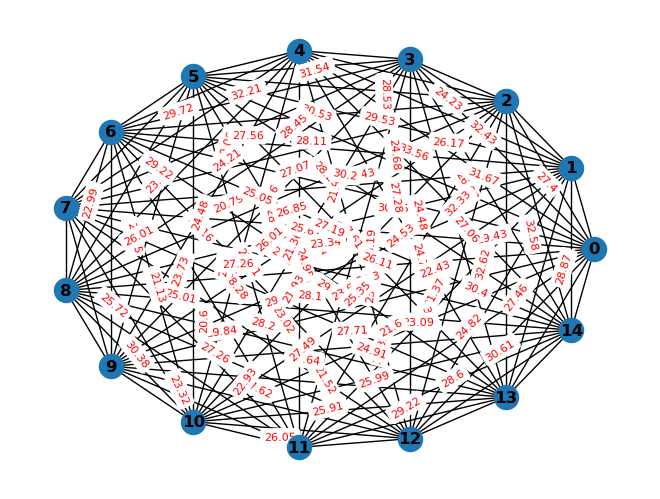

In [220]:
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels, font_size=8, font_color='red')


Linear regression to extract coefficients

In [221]:
#data prep

def prepare_regression_data(G, attributes, max_hours):
    '''Prepares data for regression'''
    data = []

    for node1, node2, edge in G.edges(data=True):
        row = {}

        for attr in attributes:
            value1 = G.nodes[node1].get(attr, 0)
            value2 = G.nodes[node2].get(attr, 0)

            # Absolute differences for continuous attributes
            if isinstance(value1, (int, float)) and isinstance(value2, (int, float)):
                row[attr] = - abs(value1 - value2) #minus because distance has negative contribution to hours
            
            # Binary differences for categorical attributes
            elif isinstance(value1, str) and isinstance(value2, str):
                row[attr] = - 1 if value1 != value2 else 0 #minus because distance has negative contribution to hours
                
        row['target'] = edge['weight']
        data.append(row)      

    return pd.DataFrame(data)

Regression

In [222]:
attributes = list(support_group_data.columns.values)
regression_data = prepare_regression_data(G, attributes, MAX_HOURS)

X = regression_data[attributes]
Y = regression_data['target']

#fit
model = LinearRegression()
model.fit(X, Y)

recovered_weights = pd.Series(model.coef_, index=attributes).to_dict()


Comparison

In [223]:
# Combine into a DataFrame for comparison
comparison = pd.DataFrame({
    'Base Weights': BASE_WEIGHTS,
    'Recovered Weights': recovered_weights
})

# Display the comparison
print(comparison)

                           Base Weights  Recovered Weights
age                                0.20           0.042119
income                             0.15           0.000118
openness                           0.10           0.526968
conscientiousness                  0.10           0.526913
extraversion                       0.10           0.526679
agreeableness                      0.10           0.528121
neuroticism                        0.10           0.527090
depressed_mood                     0.05           0.351604
anhedonia                          0.05           0.350759
weight_change                      0.05           0.352054
sleep_disturbance                  0.05           0.351175
psychomotor                        0.05           0.351361
fatigue                            0.05           0.350841
worthlessness                      0.05           0.350935
concentration                      0.05           0.351299
suicidal_ideation                  0.05           0.3515

Regenerate a graph with recovered weights

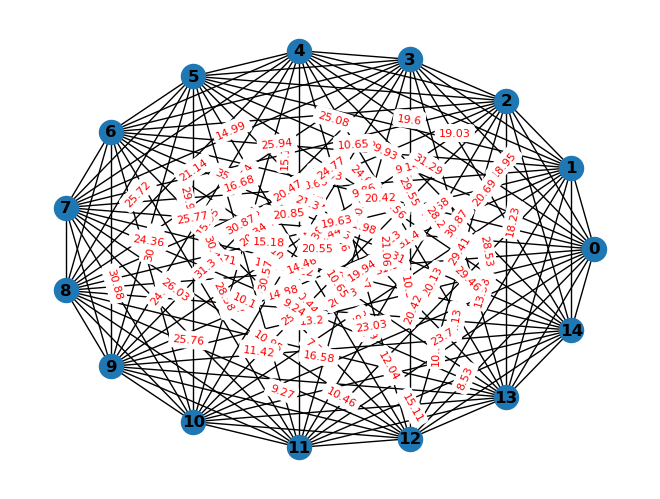

In [224]:
G_recovered = nx.complete_graph(n)

#assign attributes to the recovered graph (same as in the original graph)
for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

#assign weights based on homophily function
for node1, node2 in G_recovered.edges():
    weight = homophily_function(node1, node2, G, recovered_weights)
    G_recovered.edges[node1, node2]['weight'] = weight

#display graph
pos=nx.circular_layout(G_recovered)
nx.draw(G_recovered, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G_recovered, 'weight')
nx.draw_networkx_edge_labels(G_recovered, pos=nx.spring_layout(G_recovered), edge_labels=edge_labels, font_size=8, font_color='red');

Compare original network with recovered

In [225]:
nx.graph_edit_distance(G, G_recovered)

0.0

In [226]:
nx.is_isomorphic(G, G_recovered)

True